# Read data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import random
import re
from src.functions import *
import random
import datetime

import absl.logging #prevent checkpoint warnings while training
absl.logging.set_verbosity(absl.logging.ERROR)

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
obj_library = {}
with open("imagenet1000_clsidx_to_labels.txt") as f:
    obj_library = json.load(f)


In [3]:
def find_obj_in_text(obj_names,text):

    obj = ""
    for w in re.split("\s|(?<!\d)[,.](?!\d)",text):
        if w in obj_names:
            obj = w
    return obj
def change_obj_names(obj_names,text):
    new_objs_class = random.sample(obj_library.keys(),len(obj_names))
    new_objs = [random.choice(obj_library[o]) for o in new_objs_class]

    obj = find_obj_in_text(obj_names,text)
    if obj != "":
        new_obj = new_objs[obj_names.index(obj)]
        text = text.replace(obj,new_obj)
        obj = new_obj
    return new_objs, obj, text

def load_data(data_dir = "../data/train2", change_names =False):
    
    json_files = [pos_json for pos_json in os.listdir(data_dir) if pos_json.endswith('.json')]
    data = []
    for index, js in enumerate(json_files):
        with open(os.path.join(data_dir, js)) as json_file:
            json_text = json.load(json_file)

            #TODO: change text extraction
            text = js.split("_", 1)[1][:-8] 

            #TODO: change in the normalization
            objs_x = np.array(json_text["meta"]["o_center_x"])/json_text["meta"]["width"]
            objs_y = np.array(json_text["meta"]["o_center_y"])/json_text["meta"]["height"]


            #replace objs for random ones, avoids repetive obj names
            obj_names = json_text["meta"]["obj_names"]
            obj = ""

            if change_names:
                new_objs, obj, text = change_obj_names(obj_names,text)
            else:
                new_objs = obj_names
                obj = find_obj_in_text(obj_names,text)

            
            #TODO: add radius
            data.append({"input_traj":json_text["input_traj"],
                        "output_traj":json_text["output_traj"],
                        "text":text,
                        "obj_names":new_objs,
                        "obj_poses":np.stack([objs_x,objs_y],axis = 0),
                        "obj_in_text":obj
                        })
            # print(data)
            # break

    return data
data = load_data(data_dir = "../data/train", change_names=True) + load_data(data_dir = "../data/train2/train2", change_names=True)


# Model
## Text embeding

In [4]:
from src.motion_refiner import Motion_refiner

traj_n = 10
mr = Motion_refiner(traj_n = traj_n)

## ------- processed data -------
# X,Y = mr.prepare_data(data,deltas=True)
# print("X: ",X.shape)
# print("Y: ",Y.shape)

## ------- save pre processed data -------
# mr.save_XY(X, Y, x_name="X_delta_new_names",y_name="Y_delta_new_names")
# mr.save_data(data,data_name="data_delta_new_names")

# ------- load data --------
X_, Y_ = mr.load_XY(x_name="X_delta_new_names",y_name="Y_delta_new_names")
data_ = mr.load_data(data_name="data_delta_new_names")
feature_indices, obj_sim_indices, obj_poses_indices, traj_indices = mr.get_indices()



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
Y_abs = Y_+ X_[:,traj_indices]

X,Y, data, i_invalid = filter(X_,Y_abs,data_) #for delta predictions
# X,Y, data, i_invalid = filter(X_,Y_abs,data_,lower_limit=0) #for wp predictions

print("X:",X_.shape,"\tY:",Y_.shape)
print("filtered X:",X.shape,"\tY:",Y.shape)

print(limits(X[:,traj_indices]))
print(limits(Y))
Y_discrete = tokenize(Y)
X_traj_discrete = tokenize(X[:,traj_indices])

print(limits(Y_discrete))
print(limits(X_traj_discrete))


X: (10319, 797) 	Y: (10319, 20)
filtered X: (9836, 797) 	Y: (9836, 20)
((9836, 20), 0.04248517986117287, 0.9655699813120886)
((9836, 20), -0.6532106613067227, 0.9798744424759291)
((9836, 20), -652, 980)
((9836, 20), 43, 966)


0.0


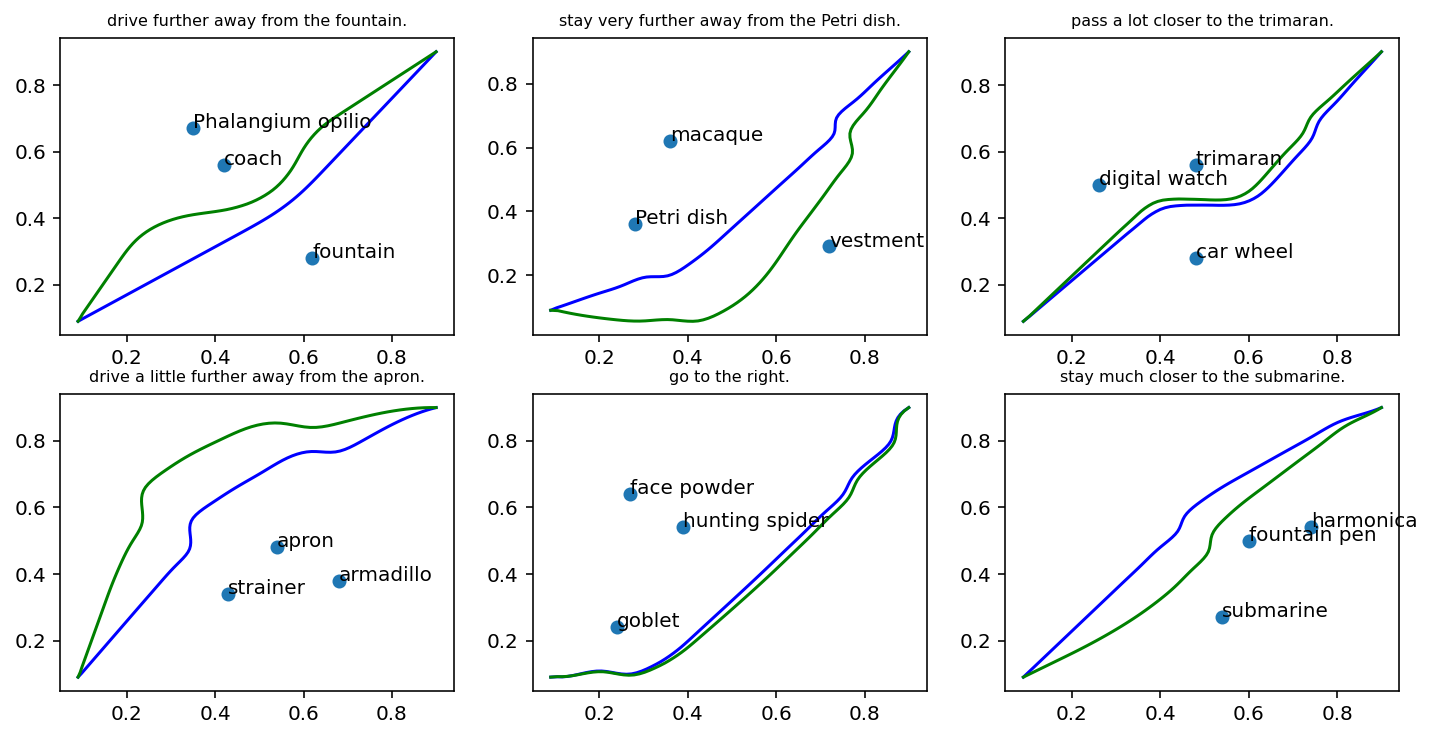

acc:  0.9969856819894499


0.9969856819894499

In [4]:
show_data(random.choices(data,k=6))
mr.evaluate_obj_matching(data)

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
from keras import backend as K
from keras.models import Sequential
from keras import Model
from keras.layers import BatchNormalization,GlobalAveragePooling1D, Embedding,Flatten, Layer,Dense,Dropout,MultiHeadAttention, Attention, Conv1D ,Input,Lambda, Concatenate,LayerNormalization
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

tf.random.set_seed(42)

print("X:",X.shape,"\tY:",Y.shape)
# print("filtered: ", len(i_invalid))

# Split the data: 70% train 20% test 10% validation
n_samples, input_size = X.shape # 768+traj_n*2+max_num_objs*3
X_train_, X_test, y_train_, y_test, indices_train_, indices_test= train_test_split(X, Y,np.arange(n_samples), test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid, indices_train, indices_val = train_test_split(X_train_, y_train_, indices_train_ ,test_size=0.125, shuffle= False)
print("Train X:",X_train.shape,"\tY:",y_train.shape)
print("Test  X:",X_test.shape,"\tY:",y_test.shape)
print("Val   X:",X_valid.shape,"\tY:",y_valid.shape)



['/device:CPU:0', '/device:GPU:0']
X: (9836, 797) 	Y: (9836, 20)
Train X: (6884, 797) 	Y: (6884, 20)
Test  X: (1968, 797) 	Y: (1968, 20)
Val   X: (984, 797) 	Y: (984, 20)


2022-02-23 14:40:31.409673: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-23 14:40:31.410793: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-23 14:40:31.411183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-02-23 14:40:31.411213: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-23 14:40:31.411257: I tensorflow/stream_executor/platform

# TF continuos

In [6]:
from simple_TF_continuos import *

embedding_indices = np.concatenate([feature_indices,obj_sim_indices,obj_poses_indices])
def get_model(num_layers = 2,d_model = 128,dff = 512,num_heads = 8,dropout_rate = 0.1,wp_d=2):

  # Size of input vocab plus start and end tokens
  input_vocab_size = wp_d
  target_vocab_size = wp_d


  features_n = len(embedding_indices )

  traj_input = tf.keras.layers.Input(shape=(None,input_vocab_size),name="init_traj")
  target = tf.keras.layers.Input(shape=(None,target_vocab_size),name="shifted_target")
  features = tf.keras.layers.Input(shape=(features_n),name="features_input")


  encoder = Encoder(input_vocab_size, num_layers = num_layers, d_model = d_model, num_heads = num_heads, dff = dff, dropout = dropout_rate)
  decoder = Decoder(target_vocab_size, num_layers = num_layers, d_model = d_model, num_heads = num_heads, dff = dff, dropout = dropout_rate)

  x = encoder(traj_input)
  x = decoder([target, x,features])#, mask = encoder.compute_mask(traj_input))
  
  x = tf.keras.layers.Dense(d_model, activation="relu")(x)
  x = tf.keras.layers.Dense(d_model, activation="relu")(x)
  x = tf.keras.layers.Dense(d_model, activation="relu")(x)

  x = tf.keras.layers.Dense(target_vocab_size,activation="tanh")(x)
  

  model = tf.keras.models.Model(inputs=[traj_input, target, features], outputs=x)
  return model

model = get_model(num_layers = 4, d_model = 256,dff = 512,num_heads = 8,dropout_rate = 0.1,wp_d=2)
# model.summary()
def compile(model):
  # optimizer = tf.keras.optimizers.Adam(1e-2, beta_1=0.9, beta_2=0.98, 
  #                                      epsilon=1e-9)
  optimizer = tf.keras.optimizers.Adam(1e-4)
  # loss = tf.keras.losses.SparseCategoricalCrossentropy(
  #     from_logits=True, reduction='none')
  # optimizer = tf.keras.optimizers.Adam()
  MSE = tf.keras.losses.MeanSquaredError()
  # MSLE = tf.keras.losses.MeanSquaredLogarithmicError()
  epslon = 10e-3
  alpha = 0.01
  def custom_loss(y_true, y_pred):
    
    # maxlen = tf.shape(y_true)[1]
    # loss_mse = MSE(y_true, y_pred)
    # maxlen = tf.cast(maxlen, dtype=loss_mse.dtype)
    loss_mse = tf.reduce_mean(tf.square(y_true-y_pred))
    loss_log = tf.reduce_mean(tf.square(y_true-y_pred))
    _loss = tf.add(loss_mse,tf.math.multiply(alpha,loss_log))
    return loss_log
  loss = MSE

  def masked_loss(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    _loss = loss(y_true, y_pred)

    mask = tf.cast(mask, dtype=_loss.dtype)
    _loss *= mask

    return tf.reduce_sum(_loss)/tf.reduce_sum(mask)
  metrics = [loss]#, masked_loss]
  model.compile(optimizer=optimizer, loss = MSE, metrics = metrics)
compile(model)

2022-02-23 14:40:32.657537: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-23 14:40:32.657979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-02-23 14:40:32.658031: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-23 14:40:32.658058: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-23 14:40:32.658076: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-02-23 14:40:32.658091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.

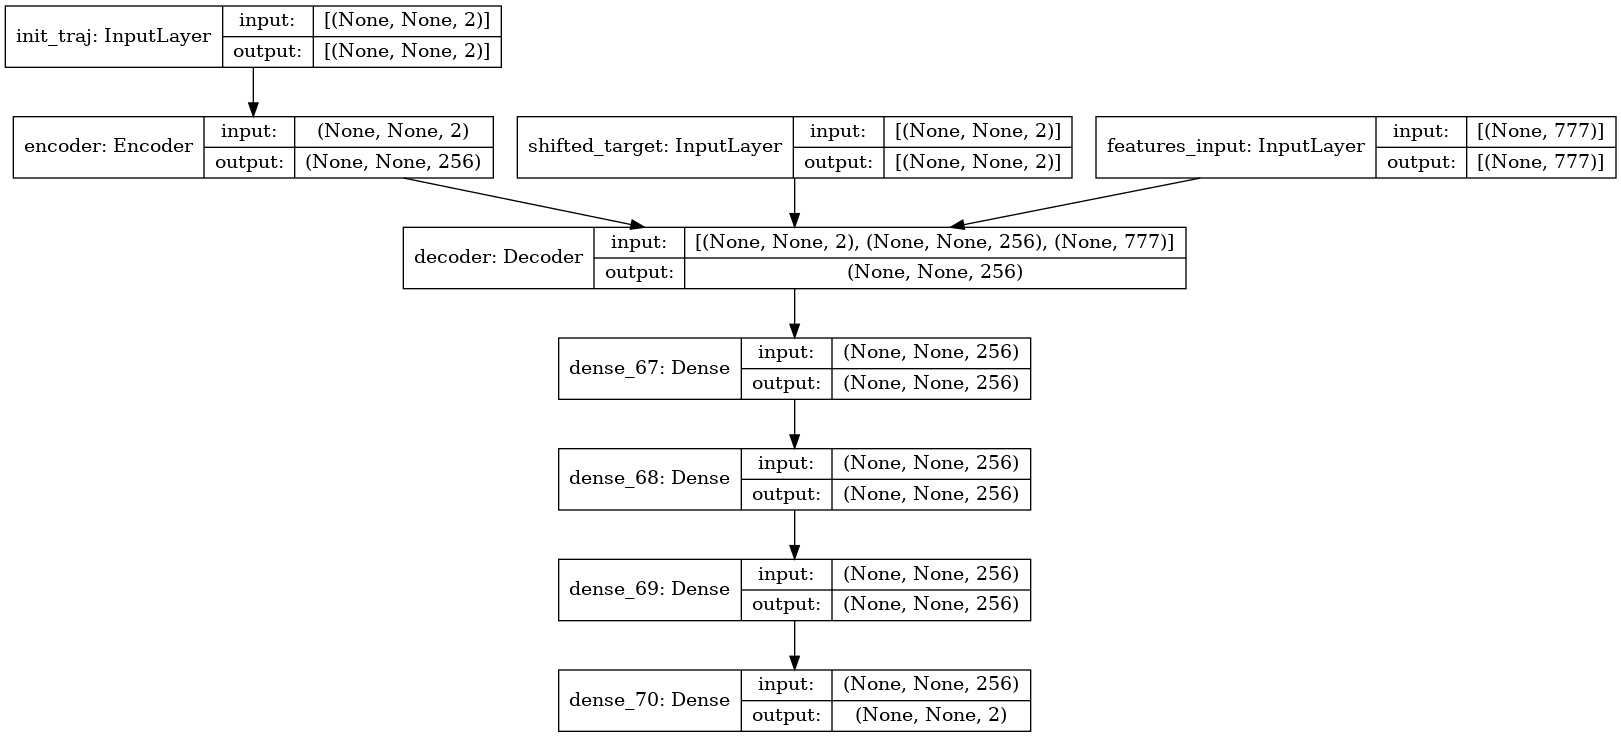

In [7]:
tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

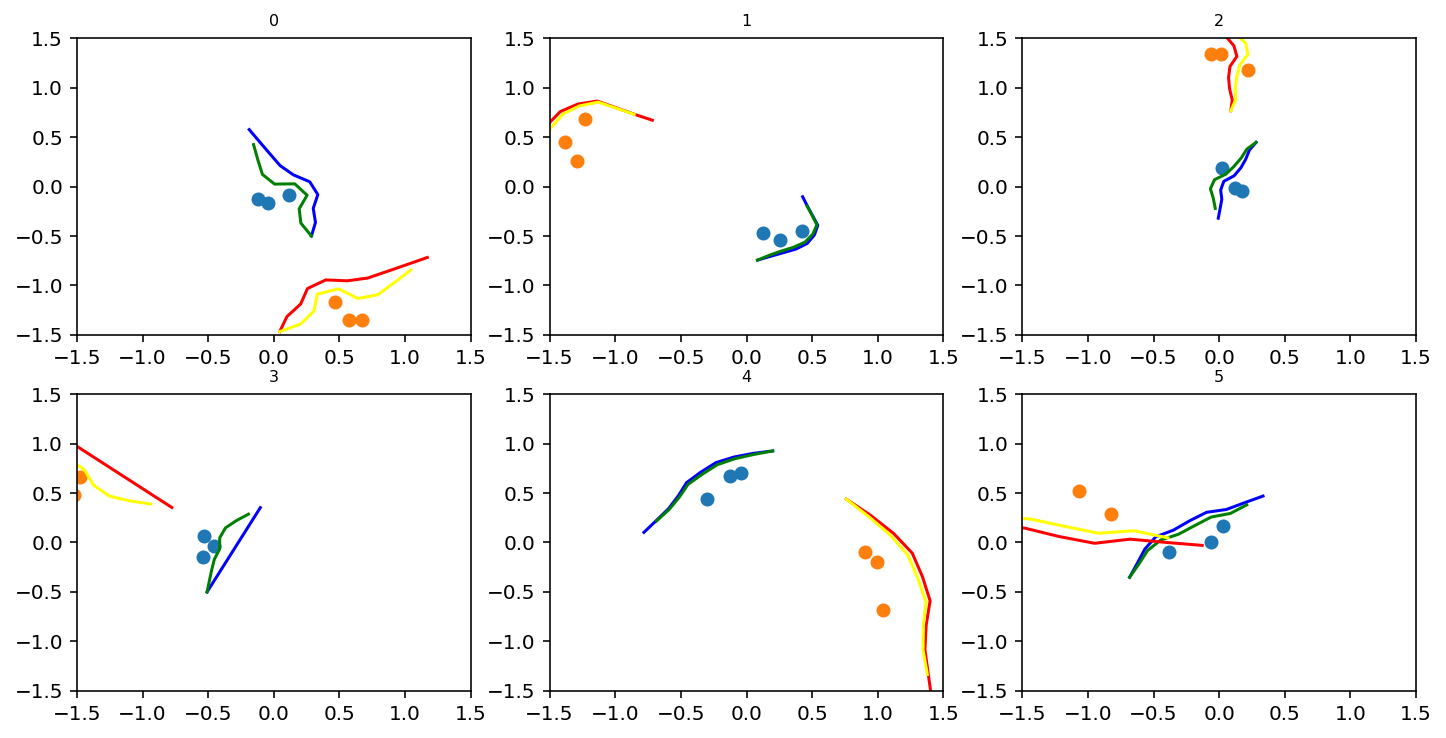

In [13]:

def generator(data_set,stop=False,augment=True):

    while True:
        for x, y,emb in data_set:
            x_new, y_new = x,y
            if augment:
                x_new, y_new = augment_xy(x,y,width_shift_range=0.5, height_shift_range=0.5,rotation_range=np.pi,
                        zoom_range=[0.5,1.2],horizontal_flip=True, vertical_flip=True, offset=[-0.5,-0.5])
            yield ( [x_new , y_new[:, :-1],emb] , y_new[:, 1:] )
        if stop:
            break

bs=6
s = 128
def prepare_x(x):
  objs = list_to_wp_seq(x[:,obj_poses_indices])
  trajs = list_to_wp_seq(x[:,traj_indices])
  return np.concatenate([objs,trajs],axis = 1)

train_dataset = tf.data.Dataset.from_tensor_slices((prepare_x(X_train),
                                                  list_to_wp_seq(y_train),
                                                  X_train[:,embedding_indices])).batch(bs)
g = generator(train_dataset)
for i in range(1):
    source, y = next(g)
    x,_,emb = source
    x_new, y_new = augment_xy(x,y,width_shift_range=0.5, height_shift_range=0.5,rotation_range=np.pi,
                        zoom_range=[0.5,1.5],horizontal_flip=True, vertical_flip=True, offset=[-0.5,-0.5])
    plot_XY(x,y)
    plot_XY(x_new, y_new,new_fig=False, cx="red",cy="yellow",x_lim=[-1.5,1.5],y_lim = [-1.5,1.5])
    

    

array([ 1, -1, -1,  1, -1])

In [ ]:
bs=64
s = 128
def prepare_x(x):
  objs = list_to_wp_seq(x[:,obj_poses_indices])
  trajs = list_to_wp_seq(x[:,traj_indices])
  return np.concatenate([objs,trajs],axis = 1)
  
embedding_indices = np.concatenate([feature_indices,obj_sim_indices])

train_dataset = tf.data.Dataset.from_tensor_slices((prepare_x(X_train),
                                                  list_to_wp_seq(y_train),
                                                  X_train[:,embedding_indices])).batch(bs)
val_dataset = tf.data.Dataset.from_tensor_slices((prepare_x(X_valid),
                                                  list_to_wp_seq(y_valid),
                                                  X_valid[:,embedding_indices])).batch(bs)
test_dataset = tf.data.Dataset.from_tensor_slices((prepare_x(X_test),
                                                  list_to_wp_seq(y_test),
                                                  X_test[:,embedding_indices])).batch(bs)

num_batches = 0
for (batch, (_,_,_)) in enumerate(train_dataset):
  num_batches = batch

val_batches = 0
for (batch, (_,_,_)) in enumerate(val_dataset):
  val_batches = batch

print(num_batches,val_batches)
  
# def generator(data_set,stop=False):
#   while True:
#     for x, y,emb in data_set:
#       yield ( [x , y[:, :-1],emb] , y[:, 1:] )
#     if stop:
#       break

logdir = os.path.join("logs/fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

earlly_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  mode='min', verbose=2, patience=30)
tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('TF_continuos_model_1.h5', verbose=0,
                                                    monitor='val_loss', mode='min', save_best_only=True)
absl.logging.set_verbosity(absl.logging.ERROR)  #prevent checkpoint warnings while training

for lr,ep in [(5e-4,30),(1e-4,100),(5e-5,100),(1e-5,100)]:
  # TRAIN
  initial_epoch = model.optimizer.iterations.numpy() // num_batches
  print("LR: ",lr," epochs: ",initial_epoch, " to ",ep)
  if initial_epoch == 0:
    reset_logs("logs")

  K.set_value(model.optimizer.learning_rate, 2e-4)
  history = model.fit(x = generator(train_dataset),epochs=initial_epoch+100, steps_per_epoch = num_batches, verbose=0,
                      callbacks=[earlly_stop_cb, tensorboard_cb, checkpoint_cb], initial_epoch=initial_epoch,
                      validation_data = generator(val_dataset), validation_steps = val_batches)
  # EVALUATION
  result= model.evaluate(generator(test_dataset,stop=True))
  print('test loss:', result[0])

In [12]:
new_model = get_model(num_layers = 4, d_model = 256,dff = 512,num_heads = 8,dropout_rate = 0.1,wp_d=2)
new_model.load_weights('TF_continuos_model_1.h5')
compile(new_model)
new_model.evaluate(generator(test_dataset,stop=True))


31/31 [==============================] - 6s 23ms/step - loss: 3.5843e-04 - mean_squared_error: 3.5848e-04


[0.0003615799068938941, 0.00036235296283848584]

In [ ]:
# model_base = get_model()
# model_base.save('TF_continuos_model',include_optimizer=False,save_format="tf")
# model.save('TF_continuos_model',save_format="tf")
# model2 = keras.models.load_model('TF_continuos_model', compile=False,custom_objects={'Encoder':Encoder,'Decoder':Decoder})
# model2 = tf.keras.models.load_model('TF_continuos_model.h5', compile=False,custom_objects={'Encoder':Encoder,'Decoder':Decoder})
# model2 = tf.keras.models.load_model('best_TF_continuos_model.h5', custom_objects={'Encoder':Encoder,'Decoder':Decoder})
# model2.load_weights('best_TF_continuos_model')

In [31]:
def generate(model, source, init_dec_input=0.1):
    """Performs inference over one batch of inputs using greedy decoding."""
    traj, shifted_target, features=source
    bs = tf.shape(traj)[0]
    dec_input = traj[:,3:4,:]#tf.ones((bs, 1,2)) * init_dec_input
    for i in range(traj_n - 1):
        dec_out = model.predict([traj,dec_input,features])
        dec_input = tf.concat([dec_input, dec_out[:, -1:,:]], axis=1)
    return dec_input

test_dataset = tf.data.Dataset.from_tensor_slices((prepare_x(X_test),
                                                  list_to_wp_seq(y_test),
                                                  X_test[:,embedding_indices])).batch(X_test.shape[0])
g = generator(test_dataset)
x_t, y_t = next(g)
pred = generate(new_model,x_t).numpy()
print(np.average((y_t - pred[:,1:,:])**2))
# print(pred.shape)

0.0033147085541431853


In [17]:
print(np.average((y_t - np.zeros_like(pred[:,1:,:]))**2))


0.3561908168279516


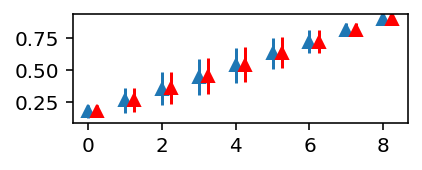

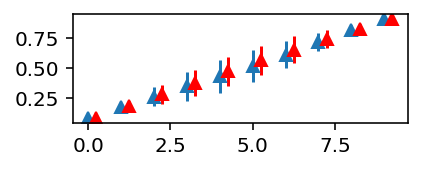

0.005021451378436668


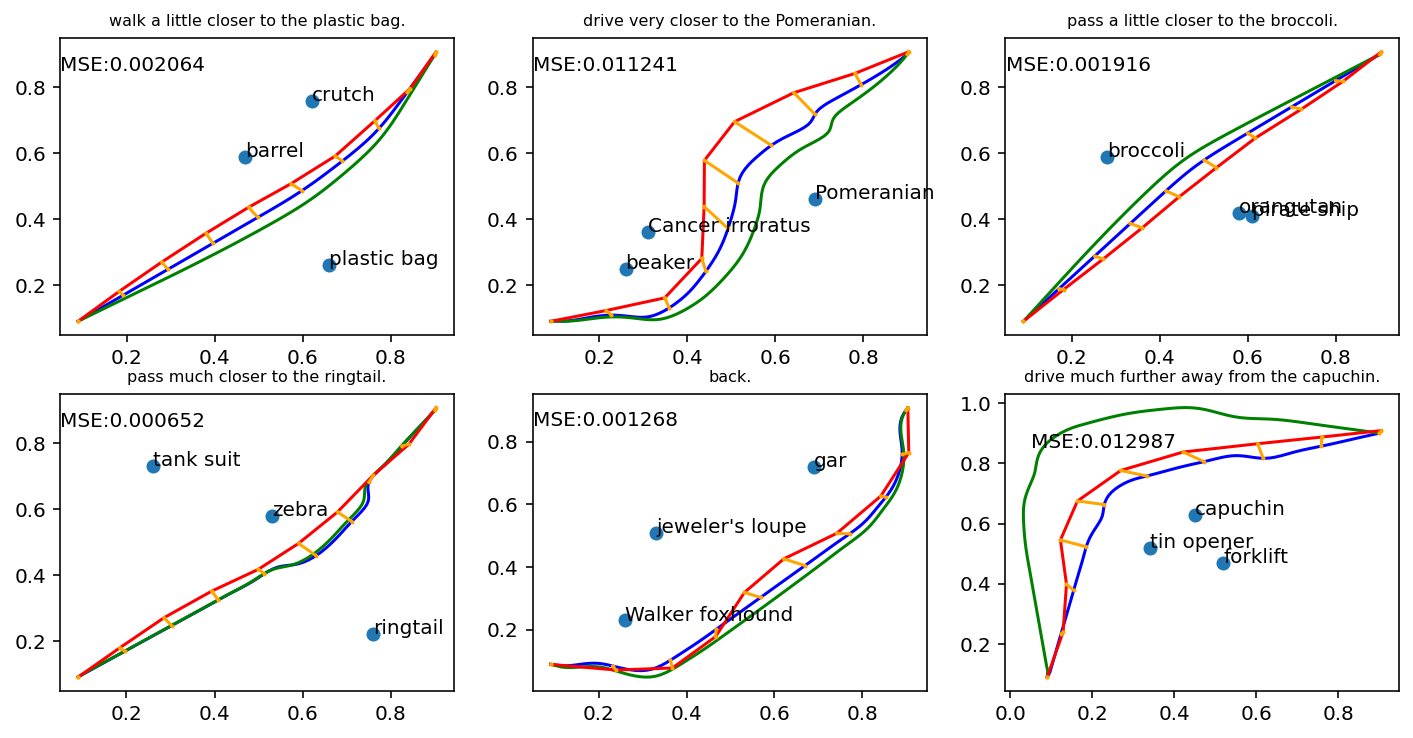

In [35]:
indices = np.random.choice(range(len(indices_test)), 6)
pred_t = np.transpose(pred[:,:,:2],[0,2,1])

def plot_dist(x):
    plt.figure(figsize=(3,1))
    avr = np.average(x,(0))
    e = np.std(x,(0))
    plt.errorbar(np.arange(len(avr[0,:])), avr[0,:], e[0,:], linestyle='None', marker='^')
    plt.errorbar(np.arange(len(avr[1,:]))+0.25, avr[1,:], e[1,:], linestyle='None', marker='^',color="red")

    plt.show()
plot_dist(np.transpose(y_t[:,:,:2],[0,2,1]))
plot_dist(pred_t)

pred_d = pred_t.reshape([pred_t.shape[0],pred_t.shape[2]*2])

data_array = np.array(data)[indices_test[indices]]
show_data(data_array, pred = pred_d[indices], abs_pred=True)

# TF discrete

In [17]:
from simple_TFs import *


# Y_discrete = tokenize(Y_train)
# X_traj_discrete = tokenize(X_train[:,traj_indices])

# Hyperparameters
num_layers = 2
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

# Size of input vocab plus start and end tokens
input_vocab_size = 102
target_vocab_size = 102

embedding_indices = np.concatenate([feature_indices,obj_sim_indices,obj_poses_indices])
features_n = len(embedding_indices )

traj_input = tf.keras.layers.Input(shape=(None,),name="init_traj")
target = tf.keras.layers.Input(shape=(None,),name="shifted_target")
features = tf.keras.layers.Input(shape=(features_n),name="features_input")

encoder = Encoder(input_vocab_size, num_layers = num_layers, d_model = d_model, num_heads = num_heads, dff = dff, dropout = dropout_rate)
decoder = Decoder(target_vocab_size, num_layers = num_layers, d_model = d_model, num_heads = num_heads, dff = dff, dropout = dropout_rate)

x = encoder(traj_input)
x = decoder([target, x,features] , mask = encoder.compute_mask(traj_input))
x = tf.keras.layers.Dense(target_vocab_size)(x)

model = tf.keras.models.Model(inputs=[traj_input, target, features], outputs=x)

# model.summary()

# optimizer = tf.keras.optimizers.Adam(0.1, beta_1=0.9, beta_2=0.98, 
#                                      epsilon=1e-9)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def masked_loss(y_true, y_pred):
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  _loss = loss(y_true, y_pred)

  mask = tf.cast(mask, dtype=_loss.dtype)
  _loss *= mask

  return tf.reduce_sum(_loss)/tf.reduce_sum(mask)


metrics = [loss, masked_loss, tf.keras.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss = loss, metrics = metrics) # masked_


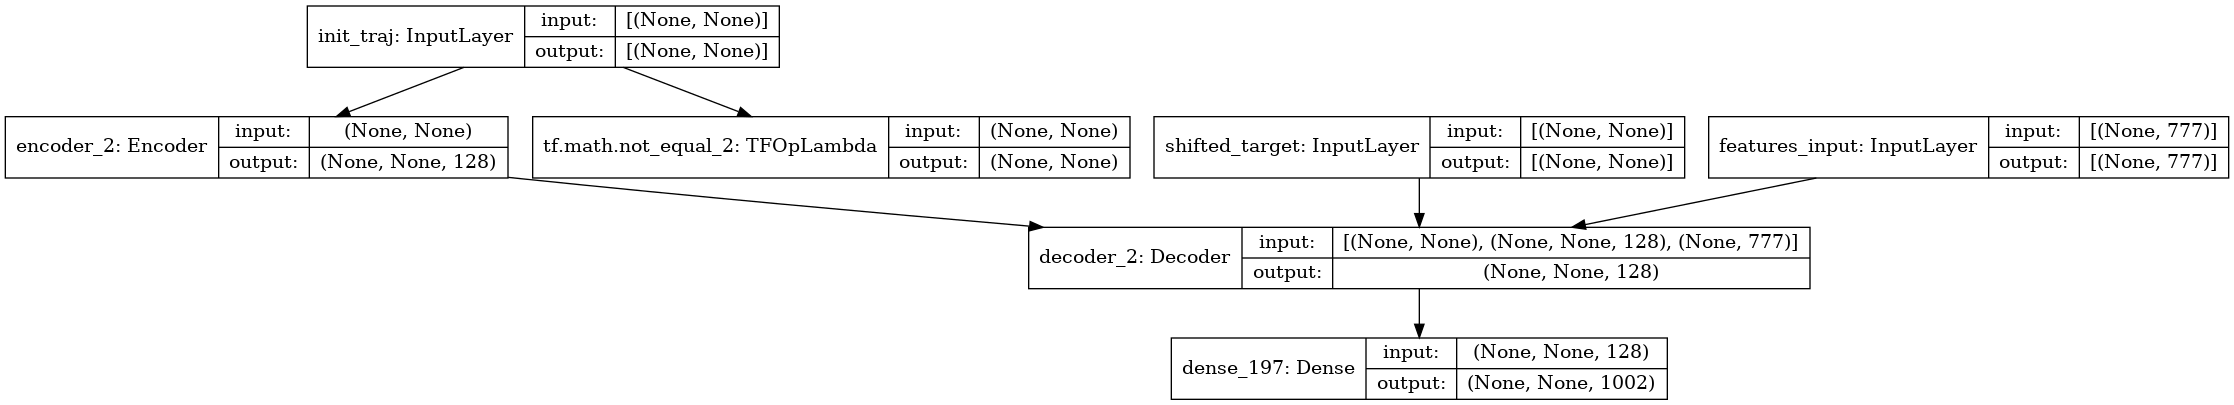

In [14]:
tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [15]:
bs=256
train_dataset = tf.data.Dataset.from_tensor_slices((tokenize(X_train[:,traj_indices]),
                                                  tokenize(y_train),
                                                  X_train[:,embedding_indices])).batch(bs)
val_dataset = tf.data.Dataset.from_tensor_slices((tokenize(X_valid[:,traj_indices]),
                                                  tokenize(y_valid),
                                                  X_valid[:,embedding_indices])).batch(bs)
test_dataset = tf.data.Dataset.from_tensor_slices((tokenize(X_test[:,traj_indices]),
                                                  tokenize(y_test),
                                                  X_test[:,embedding_indices])).batch(bs)

num_batches = 0
for (batch, (_,_,_)) in enumerate(train_dataset):
  num_batches = batch

val_batches = 0
for (batch, (_,_,_)) in enumerate(val_dataset):
  val_batches = batch

print(num_batches,val_batches)
  
def generator(data_set):
  while True:
    for x, y,emb in data_set:
      yield ( [x , y[:, :-2],emb] , y[:, 2:] )

history = model.fit(x = generator(train_dataset), validation_data = generator(val_dataset), epochs=1, steps_per_epoch = num_batches, validation_steps = val_batches)

26 3
26/26 [==============================] - 19s 213ms/step - loss: 6.5741 - sparse_categorical_crossentropy: 6.5741 - masked_loss: 6.5741 - sparse_categorical_accuracy: 0.0956 - val_loss: 6.3650 - val_sparse_categorical_crossentropy: 6.3650 - val_masked_loss: 6.3650 - val_sparse_categorical_accuracy: 0.1116


# Cross modal Transformer - continuos

In [ ]:
from cross_modal_TF_continuos_traj_input import *
import datetime
def prepare_y(y):
    y = np.transpose(y.reshape([y.shape[0],2,int(y.shape[1]/2)]),[0,2,1])
    # y_marker = np.zeros([y_.shape[0],y_.shape[1],1])
    # y_marker[:,0,0] = -0.5  #begining of the traj
    # y_marker[:,-1,0] = 0.5 #end of traj
    # return np.concatenate((y_,y_marker),axis=2) 
    return y
    
model = Transformer(
    num_hid=200,
    num_head=8,
    num_feed_forward=512,
    target_maxlen=traj_n,
    source_maxlen=input_size,
    num_layers_enc=2,
    num_layers_dec=2,
    num_classes=traj_n,
)
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
logdir = "logs"

import shutil
try:
    shutil.rmtree(logdir)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

logdir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

earlly_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  mode='min', verbose=2, patience=10)
tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best_cross_modal_model', save_format="tf",monitor='val_loss', mode='min', save_best_only=True)

loss = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam()
# opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss=loss, optimizer=opt, metrics=[tf.keras.metrics.MeanSquaredError(name='MSE')])

# # TRAIN
# history = model.fit(ds, epochs=15, batch_size=3000, callbacks=[callback],verbose=1)
history = model.fit(X_train, prepare_y(y_train), epochs=50, batch_size=128, callbacks=[earlly_stop_cb, tensorboard_cb,checkpoint_cb], validation_data=(X_valid, prepare_y(y_valid)),verbose=1)
model.save('best_cross_att_model2',save_format='tf')

# EVALUATION
result_self_at = model.evaluate(X_test, prepare_y(y_test))
print('test loss:', result_self_at)

In [ ]:
h=model.fit(X_train, prepare_y(y_train), epochs=150, batch_size=128, callbacks=[earlly_stop_cb, tensorboard_cb], validation_data=(X_valid, prepare_y(y_valid)),verbose=1, initial_epoch=len(history.history['loss']))
# history.append(h)
model.save('best_cross_att_model2',save_format='tf')

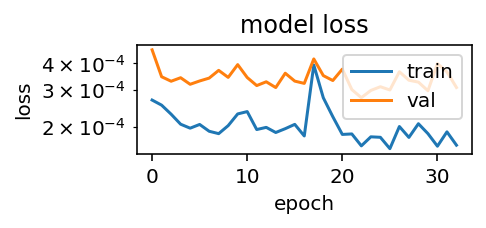

In [31]:
plot_loss(history)

In [48]:
indices = np.random.choice(range(len(indices_test)), 6)

def generate(model, source, target_start_token_idx,y=None):
    """Performs inference over one batch of inputs using greedy decoding."""
    bs = tf.shape(source)[0]
    enc = model.encoder(source)
    init_input = tf.ones((bs, 1,2)) * target_start_token_idx
    
    # dec_input = tf.concat([tf.zeros((bs,1,2)),init_input] ,axis = 2)
    dec_input = init_input
    print("Generate dec_input:",dec_input.shape)
    # print(dec_input)
    
    # dec_input = prepare_y(y_test)[:,:,:]
    # print("enc:",enc.shape)

    # for i in range(model.target_maxlen - 1):
    #     dec_out = model.decode(enc, dec_input)
    #     pred = model.classifier(dec_out)
    #     # dec_input [:,i+1,:] = pred[:,i,:]


    #     last_logit = pred[:, -1,:]
    #     last_logit = tf.expand_dims(last_logit,axis=1)
    #     dec_input = tf.concat([dec_input[:,:i+1,:], pred[:,i:i+1,:],dec_input[:,i+2:,:]], axis=1)
    #     # print(np.average((y[:,i:i+2,:2]-dec_input[:,i:,:2])**2))
    # return dec_input

    for i in range(model.target_maxlen - 1):
        dec_out = model.decode(enc, dec_input)
        pred = model.classifier(dec_out)

        last_logit = pred[:, -1,:]
        # print(last_logit[0, :])
        last_logit = tf.expand_dims(last_logit,axis=1)
        dec_input = tf.concat([dec_input, last_logit], axis=1)
        # print(np.average((y[:,i:i+2,:2]-dec_input[:,i:,:2])**2))
    return dec_input



pred = generate(model_,X_test,0,y=prepare_y(y_test)).numpy()
# model(X_test,y_test)
target = prepare_y(y_test)[:,1:,:]
# model(X_test)
print(np.average((target - pred[:,1:,:])**2))
# print(pred)

pred = np.transpose(pred[:,:,:2],[0,2,1])
def plot_dist(x):
    plt.figure(figsize=(3,1))
    avr = np.average(x,(0))
    e = np.std(x,(0))
    plt.errorbar(np.arange(len(avr[0,:])), avr[0,:], e[0,:], linestyle='None', marker='^')
    plt.errorbar(np.arange(len(avr[1,:]))+0.25, avr[1,:], e[1,:], linestyle='None', marker='^',color="red")

    plt.show()
plot_dist(np.transpose(target[:,:,:2],[0,2,1]))
plot_dist(pred)

pred = pred.reshape([pred.shape[0],pred.shape[2]*2])
# print(pred[indices])

data_array = np.array(data)[indices_test[indices]]
# print(pred)
show_data(data_array, pred = pred[indices], abs_pred=False)

Generate dec_input: (2064, 1, 2)


AttributeError: 'Transformer' object has no attribute 'target_maxlen'

## Simple NN head

In [24]:
H = []
best_model = ""
min_val_loss = 100.0
models = {}
models_path = "/home/tum/data/models/fullyconn3/"
if not os.path.exists(models_path):
    os.makedirs(models_path)
traj_n = 10

embedding_indices = np.concatenate([feature_indices,obj_sim_indices])

def generator(data_set,stop=False,augment=True):

    while True:
        for x, y,emb in data_set:
            x_new, y_new = x,y
            if augment:
                x_new, y_new = augment_xy(x,y,width_shift_range=0.5, height_shift_range=0.5,rotation_range=np.pi,
                        zoom_range=[0.5,1.5],horizontal_flip=True, vertical_flip=True, offset=[-0.5,-0.5])
            else:
                x_new, y_new = augment_xy(x,y,width_shift_range=0.0, height_shift_range=0.0,rotation_range=0.0,
                        zoom_range=0.0,horizontal_flip=False, vertical_flip=False, offset=[-0.5,-0.5])

            yield ( [x_new , y_new[:, :-1],emb] , y_new[:, 1:] )
        if stop:
            break

def linearize_gen(gen):
    while True:
        source, y = next(gen)
        x,y_shifted,emb = source
        bs = x.shape[0]
        x_flat = np.concatenate([np.reshape(x,[bs,-1]),emb],axis=1)
        y_flat = np.concatenate([np.reshape(y_shifted[:,:1,:],[bs,-1]), np.reshape(y,[bs,-1])],axis=1)
        yield (x_flat, y_flat)

def prepare_x(x):
  objs = list_to_wp_seq(x[:,obj_poses_indices])
  trajs = list_to_wp_seq(x[:,traj_indices])
  return np.concatenate([objs,trajs],axis = 1)

train_dataset = tf.data.Dataset.from_tensor_slices((prepare_x(X_train),
                                                  list_to_wp_seq(y_train),
                                                  X_train[:,embedding_indices])).batch(bs)

val_dataset = tf.data.Dataset.from_tensor_slices((prepare_x(X_valid),
                                                  list_to_wp_seq(y_valid),
                                                  X_valid[:,embedding_indices])).batch(bs)

test_dataset = tf.data.Dataset.from_tensor_slices((prepare_x(X_test),
                                                  list_to_wp_seq(y_test),
                                                  X_test[:,embedding_indices])).batch(bs)

num_batches = 0
for (batch, (_,_,_)) in enumerate(train_dataset):
  num_batches = batch

val_batches = 0
for (batch, (_,_,_)) in enumerate(val_dataset):
  val_batches = batch

nn_param = [(atv,bs,ls,dp,nh) for atv in ['linear'] for bs in [64,128] for ls in [5] for dp in [0.1] for nh in [512]]

for (atv,bs,ls,dp,nh) in nn_param:

    model = Sequential()
    model.add(Dense(nh*2, input_dim=input_size, activation='relu'))
    model.add(Dropout(dp))
    for i in range(ls):
        model.add(Dense(nh, activation='relu'))
        model.add(Dropout(dp))
    model.add(Dense(traj_n*2, activation=atv))

    logdir = os.path.join(models_path,"logs",net_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

    net_name = "fullyconn_bs"+str(bs)+"_atv"+str(atv)+"_ls"+str(ls)+"_dp"+str(dp)+"_nh"+str(nh)+".h5"
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(models_path+net_name, save_format="tf",monitor='val_loss', mode='min', save_best_only=True)
    earlly_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  mode='min', verbose=2, patience=30)
    tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


    xx,yy= next(linearize_gen(generator(train_dataset)))
    print(xx.shape,yy.shape)
    print(X_train.shape,y_train.shape)


    loss = tf.keras.losses.MeanSquaredError()
    # opt = tf.keras.optimizers.Adam(learning_rate=0.05)
    model.compile(loss=loss, optimizer="adam")
    # TRAIN
    print("--------------------------------")
    for lr,ep in [(5e-4,50),(1e-4,400),(5e-5,100),(1e-5,100)]:
        # TRAIN
        initial_epoch = model.optimizer.iterations.numpy() // num_batches

        print("LR: ",lr," epochs: ",ep,"  from:",initial_epoch, " to ",initial_epoch+ep)
        # if initial_epoch == 0:
        #     reset_logs("logs")

        K.set_value(model.optimizer.learning_rate, lr)
        history = model.fit(x = linearize_gen(generator(train_dataset)),epochs=initial_epoch+ep, steps_per_epoch = num_batches, verbose=0,
                            callbacks=[earlly_stop_cb, tensorboard_cb, checkpoint_cb], initial_epoch=initial_epoch,
                            validation_data = linearize_gen(generator(val_dataset)), validation_steps = val_batches)
        
        best_index = np.argmin(history.history['val_loss'])
        val_loss = history.history['val_loss'][best_index]
        loss = history.history['loss'][best_index]



        # history = model.fit(X_train, y_train, epochs=2000, batch_size=bs, callbacks=[earlly_stop_cb , checkpoint_cb], validation_split=0.3,verbose=0)
        H.append(history)
        # EVALUATION
        result = model.evaluate(X_test, y_test)
        best_index = np.argmin(history.history['val_loss'])
        val_loss = history.history['val_loss'][best_index]
        print(net_name, '\t MSE ==>  test :', result, "\t val : ",val_loss, "\t train : ",history.history['loss'][best_index])
        models[net_name] = {"test_loss":result,"val_loss":val_loss,"loss":history.history['loss'][best_index]}
        

        if val_loss<min_val_loss:
            min_val_loss = val_loss
            best_model = net_name

2022-02-23 15:27:09.012502: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-02-23 15:27:09.012543: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-02-23 15:27:09.012602: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-02-23 15:27:09.012622: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 18

In [10]:

min_test_loss = 10.0
best_model = ""
test_loss = 10.0
names_list = []
test_loss_list = []
for i,m in models.items():
    test_loss = m["test_loss"]
    test_loss_list.append(test_loss)
    names_list.append((i,test_loss))

    if test_loss<min_test_loss:
        min_test_loss = test_loss
        best_model = i
print(best_model, min_test_loss)

def get_test_loss(x):
    return x[1]
names_list.sort(key=get_test_loss)
# print(names_list)
model = tf.keras.models.load_model(models_path+best_model)
result = model.evaluate(X_test, y_test)


fullyconn_bs128_atvtanh_ls5_dp0.1_nh256.h5 0.0047065154649317265
65/65 [==============================] - 0s 1ms/step - loss: 0.0043


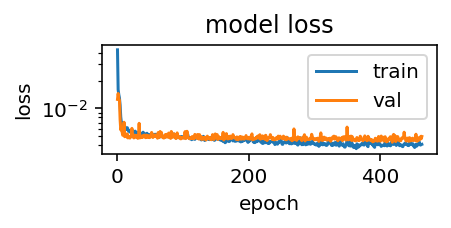

In [11]:
plot_loss(history)

[1436 1989 1394  213 1859 1381]
1/1 [==============================] - 0s 14ms/step - loss: 0.0093
test loss:  0.009282989427447319
MSE samples:  0.009282989111832944


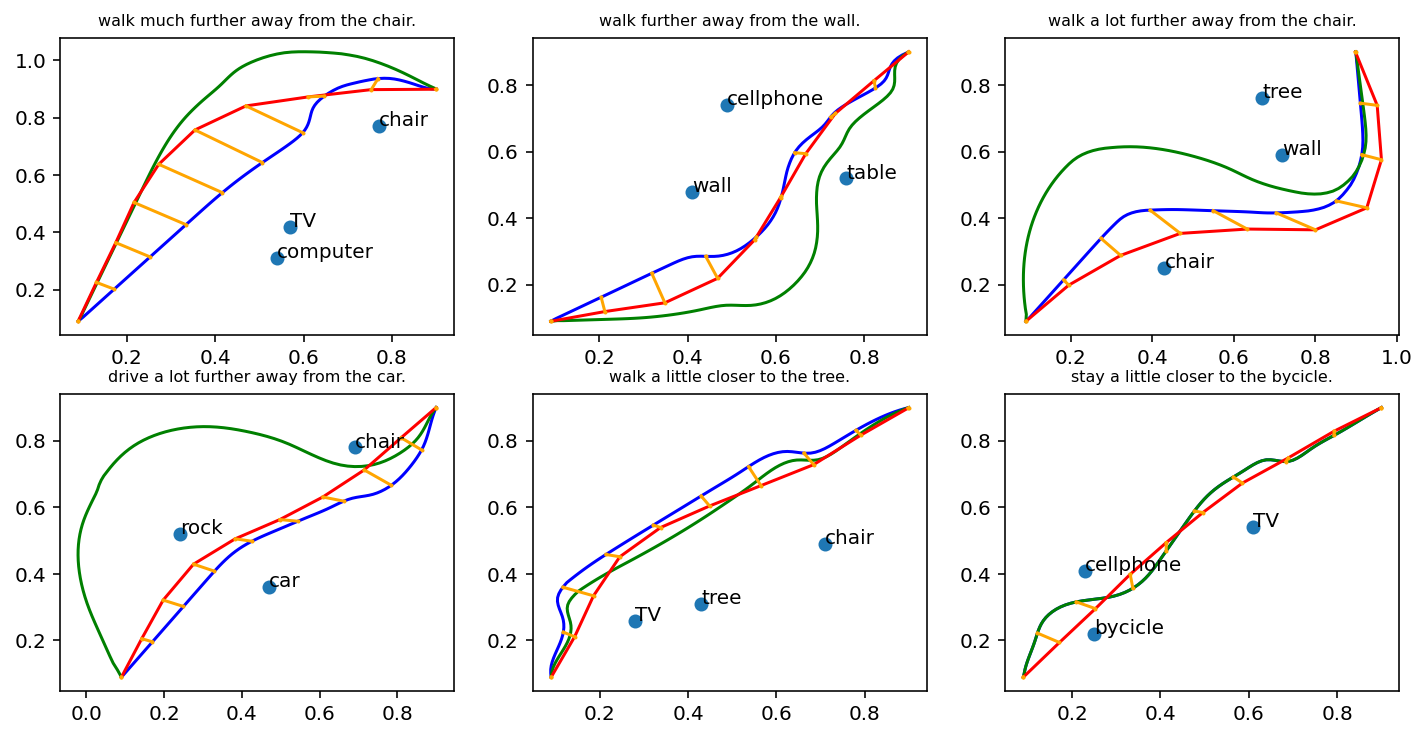

In [14]:
indices = np.random.choice(range(len(indices_test)), 6)

print(indices)

pred = model.predict(X_test)

result = model.evaluate(X_test[indices], y_test[indices])
print('test loss: ', result)
print('MSE samples: ', np.average((pred[indices]-y_test[indices])**2))

data_array = np.array(data)[indices_test[indices]]
show_data(data_array, pred = pred[indices],abs_pred=True)

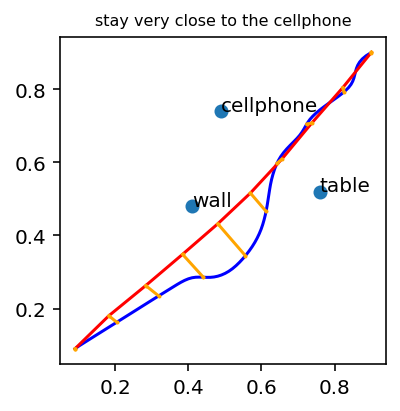

In [29]:
def apply_interaction(model, d,text):
    data_new  = []
    data_new.append({"input_traj":d["input_traj"],"output_traj":d["output_traj"],"text":text,"obj_names":d["obj_names"],
                    "obj_poses":d["obj_poses"]})

    x, _ = motion_refiner.prepare_data(data_new)
    pred_new = model.predict(x)
    show_data(data_new, pred = pred_new, abs_pred=True, show_label=False)

index = 1989
text = "stay very close to the cellphone"
d = np.array(data)[indices_test[index]]
apply_interaction(model,d, text)


# Self attention head

In [ ]:
in_l =Input(shape=input_size)
# l = Attention(use_scale=True, dropout=0.1)([in_l,in_l])
# l = LayerNormalization(epsilon=1e-6)(l)
num_hid = 128
encoder = CrossModalEmbedding(num_hid=num_hid, maxlen=10, num_layers = 2, num_classes=10000, num_heads = 2, features_n = 768, num_feed_forward = 256, source_maxlen=797)

l = encoder(in_l)
print(l.shape)
# l = Dense(512, trainable=True, activation='relu')(in_l)
# l = Dropout(0.1)(l)
# l = Dense(512, trainable=True, activation='relu')(l)
# l = Dropout(0.1)(l)
# l = Dense(256, trainable=True, activation='relu')(l)
# l = Dropout(0.1)(l)
# l = Dense(256, trainable=True, activation='relu')(l)
# l = Concatenate(axis=1)([l, in_l])
# l2 = LayerNormalization(epsilon=1e-6)(l)
# l = Dropout(0.1)(l2)
# l = Dense(256, trainable=True, activation='relu')(l)
# l = Dropout(0.1)(l)
# l = Dense(256, trainable=True, activation='relu')(l)
# l = Concatenate(axis=1)([l, l2])
# l = LayerNormalization(epsilon=1e-6)(l)
l = Flatten()(l)
l = Dense(256, trainable=True, activation='relu')(l)
l = Dropout(0.1)(l)
outputs = Dense(traj_n*2, trainable=True, activation='tanh')(l)
model=Model(in_l,outputs)


earlly_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  mode='min', verbose=1, patience=30)
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
logdir = "logs"

tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best_res_model.h5', save_format="tf",monitor='val_loss', mode='min', save_best_only=True)

loss = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam()

model.compile(loss=loss, optimizer=opt, metrics=[tf.keras.metrics.MeanSquaredError(name='MSE')])

# # TRAIN
history_self_at = model.fit(X_train, y_train, epochs=10, batch_size=128, callbacks=[earlly_stop_cb, tensorboard_cb, checkpoint_cb], validation_data=(X_valid,y_valid),verbose=1)

# EVALUATION
result_self_at = model.evaluate(X_test, y_test)
print('test loss:', result_self_at[0])

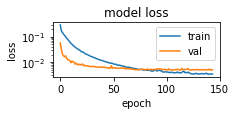

In [ ]:
plot_loss(history_self_at)

[252 149 556 388 940 484]
1/1 [==============================] - 0s 14ms/step - loss: 0.0034 - MSE: 0.0034
test loss:  [0.0034364238381385803, 0.0034364238381385803]
MSE samples:  0.0034364238539963854


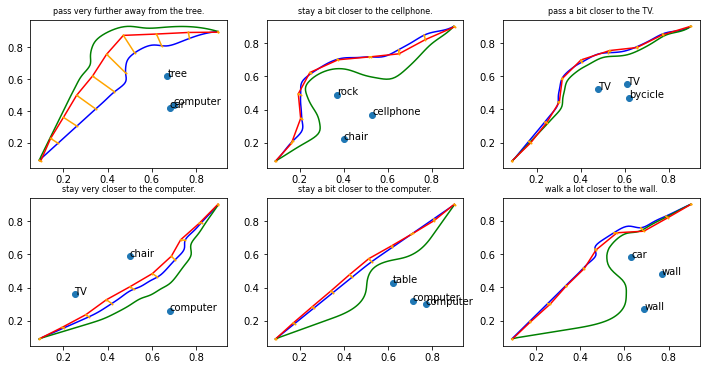

In [ ]:
indices = np.random.choice(range(len(indices_test)), 6)

print(indices)

pred = model.predict(X_test)

result = model.evaluate(X_test[indices], y_test[indices])
print('test loss: ', result)
print('MSE samples: ', np.average((pred[indices]-y_test[indices])**2))

data_array = np.array(data)[indices_test[indices]]
show_data(data_array, pred = pred[indices])

# Cross model Transformer discrete

In [9]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.self_att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.enc_att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = Dropout(0.5)
        self.enc_dropout = Dropout(0.1)
        self.ffn_dropout = Dropout(0.1)
        self.ffn = Sequential(
            [
                Dense(feed_forward_dim, activation="relu"),
                Dense(embed_dim),
            ]
        )
    def call(self, enc_out, target):

        target_att = self.self_att(target, target)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm

class TransformerDecoder(Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.self_att = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = Dropout(0.5)
        self.enc_dropout = Dropout(0.1)
        self.ffn_dropout = Dropout(0.1)
        self.ffn = Sequential(
            [
                Dense(feed_forward_dim, activation="relu"),
                Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)

        target_att = self.self_att(target, target, attention_mask=causal_mask)
        # target_att = self.self_att(target, target)


        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        # print("-----------here------------")

        # print(target_norm.shape)
        # print(enc_out.shape)

        enc_out = self.enc_att(target_norm, enc_out)
        # print("-----------DONE------------")
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm


class TrajEmbedding(Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.num_hid = num_hid
        self.num_vocab =num_vocab
        self.emb = tf.keras.layers.Embedding(num_vocab, int(num_hid/2))
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=num_hid)
        self.linear_embedding = Dense(num_hid, activation=None, use_bias=False) #only weights multiplication

    def call(self, x):
        x_shape =  tf.shape(x)
        bs = x_shape[0]
        maxlen = x_shape[1]
        # print(x.shape)
        # print("x = ",x.shape)

        x = self.emb(x)
        # x = self.linear_embedding(x)
        # print("x emb = ",x.shape)
        x = tf.reshape(x,[bs,maxlen,self.num_hid])
        # print("x emb reshape = ",x.shape)

        # x = tf.expand_dims(x, 2)

        positions = tf.range(start=0, limit=maxlen, delta=1)
        # print("pos = ",positions.shape)

        positions = self.pos_emb(positions)
        # print("pos emb = ",positions.shape)

        # positions = tf.expand_dims(positions, 1)

        out = x + positions
        # print("traj emb out = ",out.shape)

        return out
class FeatureEmbedding(Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        # self.conv1 = Conv1D(
        #     num_hid, 11, strides=2, padding="same", activation="relu"
        # )
        # self.conv2 = Conv1D(
        #     num_hid, 11, strides=2, padding="same", activation="relu"
        # )
        # self.conv3 = Conv1D(
        #     num_hid, 11, strides=2, padding="same", activation="relu"
        # )
        self.ff1 = Dense(num_hid*2,activation="relu")
        self.ff2 = Dense(num_hid,activation="relu")

        # self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.ff1(x)
        x = self.ff2(x)
        # print("x:",x.shape)
        x = tf.expand_dims(x, axis=1)
        return x


class CrossModalEmbedding(Layer):
    def __init__(self, num_hid=64, maxlen=100, num_classes=20,num_layers = 2, num_heads = 4, features_n = 768, num_feed_forward = 256, source_maxlen=817):
        super().__init__()
        self.enc_traj = TrajEmbedding(num_vocab=num_classes, maxlen=maxlen, num_hid=num_hid)
        self.enc_obj = TrajEmbedding(num_vocab=num_classes, maxlen=maxlen, num_hid=num_hid)
        self.enc_features = FeatureEmbedding(num_hid=num_hid)
        self.num_layers = num_layers


        self.slice_f = Lambda(lambda x: x[:,:features_n+3])
        self.slice_obj = Lambda(lambda x: x[:,features_n+3:-maxlen*2])
        self.slice_traj = Lambda(lambda x: x[:,-maxlen*2:])

        if num_layers>0:
            self.att_f_o = TransformerEncoder(num_hid, num_heads, num_feed_forward)
            self.att_f_t = TransformerEncoder(num_hid, num_heads, num_feed_forward)
            self.att_t_o = TransformerEncoder(num_hid, num_heads, num_feed_forward)
        # self.att_self = MultiHeadAttention(num_heads=num_heads, key_dim=num_hid)
        self.concat = Concatenate(axis=1)
    

    def vec_to_traj(self,y):
        input_shape = tf.shape(y) 
        # input_shape = y.numpy().shape
        # print(type(input_shape))
        batch_size = input_shape[0]
        seq_len = input_shape[1]

        y= tf.reshape(y,[batch_size,2,tf.dtypes.cast(tf.divide(seq_len,2),tf.int32)])
        y= tf.transpose(y,[0,2,1])
        y= tf.dtypes.cast(y*1000,tf.int32)
        # y_marker = tf.tile(self.traj_marker, multiples = [batch_size,1,1])
        # print(y_marker.shape)

        # return tf.concat([y,y_marker],axis=2)
        return y

    def call(self, source):
        
        features = self.slice_f(source)
        objs_data = self.slice_obj(source)
        traj = self.slice_traj(source)
        
        traj = self.vec_to_traj(traj)
        objs_data = self.vec_to_traj(objs_data)

        traj = self.enc_traj(traj)
        objs_data = self.enc_obj(objs_data) 
        features = self.enc_features(features)

        
        # print("enc: ",features.shape, objs_data.shape, traj.shape)

        for i in range(self.num_layers):
            f_o = self.att_f_o(objs_data,features)
            o_f = self.att_f_o(features,objs_data)
            f_t = self.att_f_t(traj,features)
            t_f = self.att_f_t(features,traj)
            o_t = self.att_t_o(traj,objs_data)
            t_o = self.att_t_o(objs_data,traj)

            # print("enc: ",features.shape, objs_data.shape, traj.shape)

            traj = t_f+t_o
            features = f_t+f_o
            objs_data = o_t+o_f
        # print("pos att: ",f_o.shape,f_t.shape,t_o.shape)
        # con = self.concat([traj,objs_data,features])

        con = self.concat([traj,features,objs_data])
        # print("con",con.shape)
        return con

class MultiLinearEmbedding(Layer):
    def __init__(self, num_hid=64):
        super().__init__()

        self.enc_lin1 = Sequential([Dense(num_hid*2, activation='relu'), Dropout(0.1),Dense(num_hid, activation='relu')])
        self.enc_lin2 = Sequential([Dense(num_hid*2, activation='relu'), Dropout(0.1),Dense(num_hid, activation='relu')])
        self.enc_lin3 = Sequential([Dense(num_hid*2, activation='relu'), Dropout(0.1),Dense(num_hid, activation='relu')])
 
    def call(self, source):
        l1 = self.enc_lin1(source)
        l1 = tf.expand_dims(l1, axis=1)
        l2 = self.enc_lin2(source)
        l2 = tf.expand_dims(l2, axis=1)
        l3 = self.enc_lin3(source)

        return l1,l2,l3
        
        
class Transformer(Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10
    ):
        super().__init__()

        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        self.acc_metric = tf.keras.metrics.Accuracy()

        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes
        self.features_n = 768
        self.num_hid = num_hid
        
        self.dec_input = TrajEmbedding(num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid)
        # self.encoder = Sequential(
        #     [self.enc_features]
        #     # + [
        #     #     TransformerEncoder(num_hid, num_head, num_feed_forward)
        #     #     for _ in range(num_layers_enc)
        #     # ]
        # )

        self.encoder = CrossModalEmbedding(num_hid=num_hid, maxlen=target_maxlen, num_layers = num_layers_enc, num_classes=num_classes, num_heads = 4, features_n=self.features_n, num_feed_forward = 256, source_maxlen=797)

        # self.encoder = MultiLinearEmbedding(num_hid=num_hid)
        
        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = Sequential([
                            Dense(256, activation='relu'),
                            Dropout(0.1),
                            Dense(256, activation='relu'),
                            Dropout(0.1),
                            Dense(num_classes*2, activation='softmax'),
                            tf.keras.layers.Reshape([-1,2,num_classes])])

    def decode(self, enc_out, target,append_enc=False,tokenize=True):
        # y = target
        # print("taget shape: ",target.shape)
        # print("dec: enc_out shape: ",enc_out.shape)

        if tokenize:
            y = self.dec_input(target)
        else:
            y = target
        if append_enc:
            enc_out = tf.concat([enc_out,y],1, name='concat_1')
        
        # print("dec: new enc_out shape: ",enc_out.shape)
        # print("dec: y shape ",y.shape)

        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        source = inputs[0]
        target = inputs[1]

        # -------- Cross Modal -------- 
        x = self.encoder(source)
        # print("x call: ",x.shape)
        y = self.decode(x, target)
        # y = self.decode(x, x)

        out = self.classifier(y)
        # print("y call: ",y.shape)
        # print("out: ",out.shape)

        return out

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""

        # print("batch: ",batch.shape)
        if(isinstance(batch, tuple)):
            source = batch[0]
            target = batch[1]
        else:
            source = batch["source"]
            target = batch["target"]
        # target = self.prepare_y(target)
        # print("train SOURCE: ",source.shape)
        dec_input = target[:, :-1,:]
        dec_target = target[:, 1:,:]
        with tf.GradientTape() as tape:

            preds = self([source, dec_input])

            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            # print(mask)

            # print("dec_target: ",dec_target.shape)
            # print("target: ",target.shape)
            # print("preds: ",preds.shape)
            # print("mask:",mask.shape)
            # print("one_hot:",one_hot.shape)

            # dec_target = Flatten()(dec_target)
            # preds = Flatten()(preds)
            # mask = Flatten()(mask)

            # preds = tf.expand_dims(preds,axis=-1)
            # dec_target = tf.expand_dims(dec_target,axis=-1)
            # mask = tf.expand_dims(mask,axis=-1)
            
            # dec_target = tf.expand_dims(dec_target,axis=-1)
            # preds = tf.expand_dims(preds,axis=-1)
            loss = self.compiled_loss(one_hot, preds)#, sample_weight=mask)


        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)

        # self.acc_metric.update_state(preds,dec_target)

        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        if(isinstance(batch, tuple)):
            source = batch[0]
            target = batch[1]
        else:
            source = batch["source"]
            target = batch["target"]

        # target = self.prepare_y(target)

        dec_input = target[:, :-1,:]
        dec_target = target[:, 1:,:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        # dec_target = tf.expand_dims(dec_target,axis=-1)

        # preds = tf.expand_dims(preds,axis=-1)
        # dec_target = tf.expand_dims(dec_target,axis=-1)
        # mask = tf.expand_dims(mask,axis=-1)

        loss = self.compiled_loss(one_hot, preds)#, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        dec_input = tf.ones((bs, 1,2), dtype=tf.int32) * target_start_token_idx

        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input
        

def prepare_y(y,n_classes = 1000):
    y = np.transpose(y.reshape([y.shape[0],2,int(y.shape[1]/2)]),[0,2,1])
    y = y*n_classes
    return y.astype('int32')
def prepare_x(x,n_classes = 1000,traj_split_index = (traj_n+3)*2):
    x[:,-traj_split_index:] = x[:,-traj_split_index:]*n_classes
    return x
    
model = Transformer(
    num_hid=200,
    num_head=8,
    num_feed_forward=512,
    target_maxlen=traj_n,
    source_maxlen=input_size,
    num_layers_enc=1,
    num_layers_dec=1,
    num_classes=1000,
)


# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
logdir = "logs"

import shutil
try:
    shutil.rmtree(logdir)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))


earlly_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  mode='min', verbose=2, patience=10)
tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best_self_att_model2.h5', save_format="tf",monitor='val_loss', mode='min', save_best_only=True)

# loss = tf.keras.losses.MeanSquaredError()
loss = tf.keras.losses.CategoricalCrossentropy( from_logits=True, label_smoothing=0.1)
opt = tf.keras.optimizers.Adam()
# opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

# # TRAIN
# history = model.fit(ds, epochs=15, batch_size=3000, callbacks=[callback],verbose=1)
history = model.fit(X_train, prepare_y(y_train), epochs=1, batch_size=128, callbacks=[earlly_stop_cb, tensorboard_cb], validation_data=(X_valid, prepare_y(y_valid)),verbose=1)
model.save('best_cross_att_model2',save_format='tf')

# EVALUATION
result_self_at = model.evaluate(X_test, prepare_y(y_test))
print('test loss:', result_self_at)


53/53 [==============================] - 15s 93ms/step - loss: 6.8670 - val_loss: 6.8583


61/61 [==============================] - 1s 10ms/step - loss: 6.8584
test loss: 6.858431816101074


In [67]:

features_n = 768

inp = Input(shape=(X.shape[1]))
l = CrossModalEmbedding(num_hid=200, maxlen=10, num_layers = 5, num_classes=1000, num_heads = 4, features_n=features_n, num_feed_forward = 256)(inp)
# l = Dense(32)(l)
l = GlobalAveragePooling1D()(l)
# l = Lambda(lambda x: x[:,-20:],output_shape=(None,32*200))(l)
print(l.shape)

l=  Dense(128 ,activation="relu")(l)
l=  Dense(20 ,activation="tanh")(l)

input_shape = tf.shape(l) 
batch_size = input_shape[0]
seq_len = input_shape[1]
l = tf.reshape(l,[batch_size,2,tf.dtypes.cast(tf.divide(seq_len,2),tf.int32)])
out = tf.transpose(l,[0,2,1])
model = Model(inp, out)

# print(prepare_y(y_train)[:1,:])

loss = tf.keras.losses.MeanSquaredError()
# loss = tf.keras.losses.CategoricalCrossentropy( from_logits=True, label_smoothing=0.1)
opt = tf.keras.optimizers.Adam()
# opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss=loss, optimizer=opt)

def prepare_y(y,n_classes = 1000):
    y = np.transpose(y.reshape([y.shape[0],2,int(y.shape[1]/2)]),[0,2,1])
    # y = y*n_classes
    return y

output = model.predict(X_train[:1,:])


(None, 200)


In [75]:
# model.summary()
history = model.fit(X_train, prepare_y(y_train), epochs=10, batch_size=128, callbacks=[earlly_stop_cb, tensorboard_cb], validation_data=(X_valid, prepare_y(y_valid)),verbose=1)
print("------------------------------")
result_self_at = model.evaluate(X_test, prepare_y(y_test))
print('test loss:', result_self_at)

Epoch 1/10
53/53 [==============================] - 9s 170ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 2/10
53/53 [==============================] - 8s 144ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 3/10
24/53 [============>.................] - ETA: 3s - loss: 0.0091

In [9]:
print(np.average((prepare_y(y_test)[:,1:,:]-prepare_y(y_test)[:,:-1,:])**2))

0.01040996685169217


226/226 [==============================] - 1s 4ms/step - loss: 4.4999e-04
train loss: 0.00044998855446465313
65/65 [==============================] - 0s 4ms/step - loss: 4.1516e-04
test loss: 0.0004151597386226058


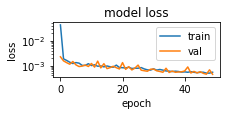

In [17]:
# # EVALUATION
result_self_at = model.evaluate(X_train, prepare_y(y_train))
print('train loss:', result_self_at)
result_self_at = model.evaluate(X_test,  prepare_y(y_test))
print('test loss:', result_self_at)

plot_loss(history)

In [ ]:
indices = np.random.choice(range(len(indices_test)), 6)

# indices = [0,1,2,3,4,5,6]

Generate dec_input: (2064, 1, 2)
0.005007297944766405


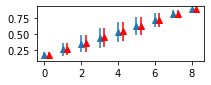

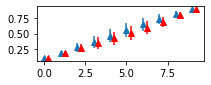

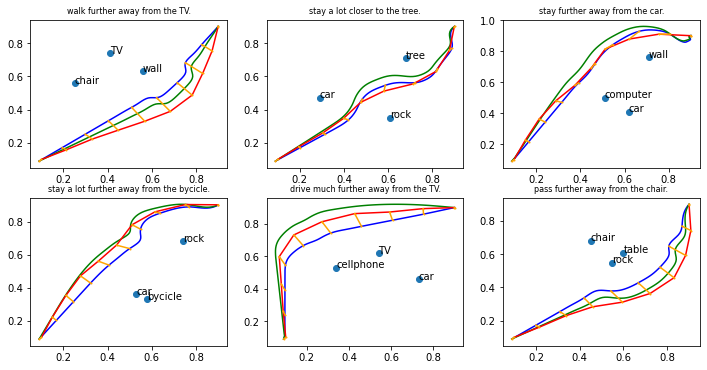

In [19]:
indices = np.random.choice(range(len(indices_test)), 6)

def generate(model, source, target_start_token_idx,y=None):
    """Performs inference over one batch of inputs using greedy decoding."""
    bs = tf.shape(source)[0]
    enc = model.encoder(source)
    init_input = tf.ones((bs, 1,2)) * target_start_token_idx
    # dec_input = tf.concat([tf.zeros((bs,1,2)),init_input] ,axis = 2)
    dec_input = init_input
    print("Generate dec_input:",dec_input.shape)
    # print(dec_input)
    
    # dec_input = prepare_y(y_test)[:,:,:]
    # print("enc:",enc.shape)

    # for i in range(model.target_maxlen - 1):
    #     dec_out = model.decode(enc, dec_input)
    #     pred = model.classifier(dec_out)
    #     # dec_input [:,i+1,:] = pred[:,i,:]


    #     last_logit = pred[:, -1,:]
    #     last_logit = tf.expand_dims(last_logit,axis=1)
    #     dec_input = tf.concat([dec_input[:,:i+1,:], pred[:,i:i+1,:],dec_input[:,i+2:,:]], axis=1)
    #     # print(np.average((y[:,i:i+2,:2]-dec_input[:,i:,:2])**2))
    # return dec_input

    for i in range(model.target_maxlen - 1):
        dec_out = model.decode(enc, dec_input)
        pred = model.classifier(dec_out)

        last_logit = pred[:, -1,:]
        # print(last_logit[0, :])
        last_logit = tf.expand_dims(last_logit,axis=1)
        dec_input = tf.concat([dec_input, last_logit], axis=1)
        # print(np.average((y[:,i:i+2,:2]-dec_input[:,i:,:2])**2))
    return dec_input



pred = generate(model,X_test,0.1,y=prepare_y(y_test)).numpy()
# model(X_test,y_test)
target = prepare_y(y_test)[:,1:,:]
# model(X_test)
print(np.average((target - pred[:,1:,:])**2))
# print(pred)

pred = np.transpose(pred[:,:,:2],[0,2,1])
def plot_dist(x):
    plt.figure(figsize=(3,1))
    avr = np.average(x,(0))
    e = np.std(x,(0))
    plt.errorbar(np.arange(len(avr[0,:])), avr[0,:], e[0,:], linestyle='None', marker='^')
    plt.errorbar(np.arange(len(avr[1,:]))+0.25, avr[1,:], e[1,:], linestyle='None', marker='^',color="red")

    plt.show()
plot_dist(np.transpose(target[:,:,:2],[0,2,1]))
plot_dist(pred)

pred = pred.reshape([pred.shape[0],pred.shape[2]*2])
# print(pred[indices])

data_array = np.array(data)[indices_test[indices]]
# print(pred)
show_data(data_array, pred = pred[indices], abs_pred=True)

In [20]:
print(np.average(y_test**2))
print(np.average(pred**2))
print(np.average((y_test-pred)**2))
print(np.average((y_test[:,0])**2))


0.3264705458389824
0.31510192
0.004516568153269997
0.0081


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True) 

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
def plot_att_matrix(model):
    #plot attention matrix
    pass
plot_att_matrix(model)

# Transformer decoder